In [1]:
"""
Importing needed libraries
"""
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from collections import Counter
import itertools

In [2]:
""" 
 Dataset path
"""
training_image_path = 'plant disease dataset/Train/Train'
validation_image_path = 'plant disease dataset/Validation/Validation'
testing_image_path = 'plant disease dataset/Test/Test'

In [3]:
""" 
Let's define the transformatiions that needed to be applied on the images. 
"""
image_transformation = transforms.Compose([
    transforms.Resize((128, 128)),  # resizing the image to 32x32
    transforms.ToTensor()  # Converting as tensor
])

In [4]:
""" 
Definig the dataset by applying transfromations on the datsset images.
"""
training_dataset = datasets.ImageFolder(
    training_image_path, transform=image_transformation)
validation_dataset = datasets.ImageFolder(
    validation_image_path, transform=image_transformation)
testing_dataset = datasets.ImageFolder(
    testing_image_path, transform=image_transformation)

In [5]:
"""  
Insights of defined dataset. 
"""

print("Size of Training Data : ", len(training_dataset))
print("Size of Validation Data : ", len(validation_dataset))
print("Size of Testing Data : ", len(testing_dataset))
print("Unique Classes : ", training_dataset.classes)

Size of Training Data :  1322
Size of Validation Data :  60
Size of Testing Data :  150
Unique Classes :  ['Healthy', 'Powdery', 'Rust']


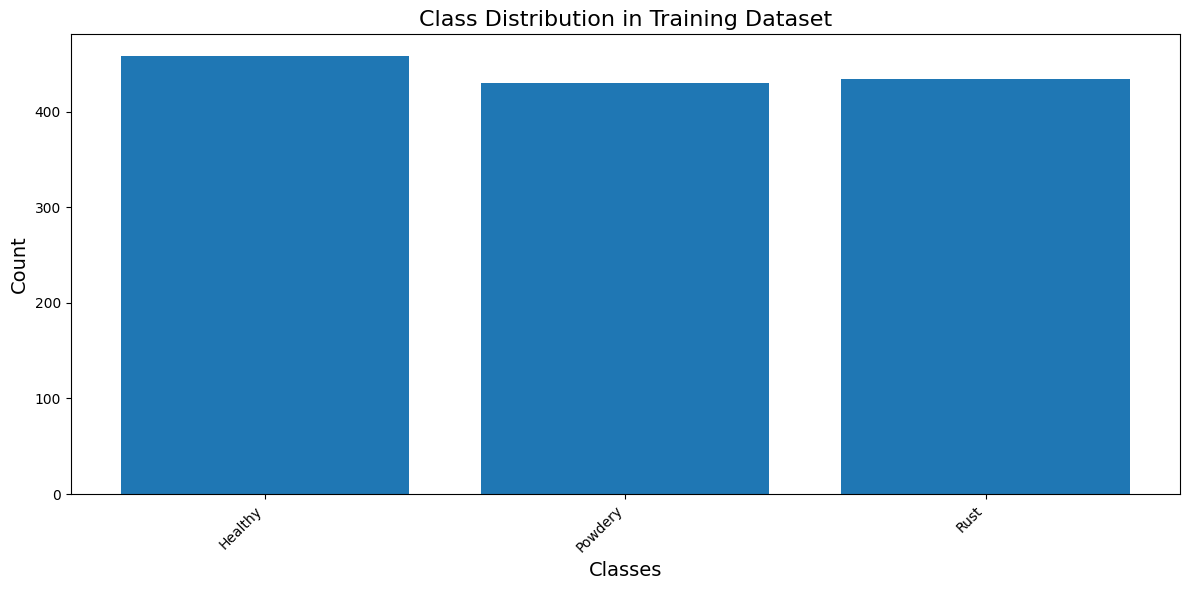

In [6]:
""" 
Visualizing the classes frequency 
"""
# Extracting class counts from the training dataset
class_counts = Counter([label for _, label in training_dataset])
class_names = training_dataset.classes

# Prepare data for plotting
class_labels = [class_names[i] for i in class_counts.keys()]
class_values = list(class_counts.values())

# Plotting the class distribution
plt.figure(figsize=(12, 6))
plt.bar(class_labels, class_values)
plt.xlabel("Classes", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.title("Class Distribution in Training Dataset", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('./plots/class_distribution.png')
plt.show()

## Base CNN model for plant disease prediction

In [34]:
""" 
Defining the dataloaders. 
    - batch_size : 32
"""
training_loader = DataLoader(training_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32)
testing_loader = DataLoader(testing_dataset, batch_size=32)

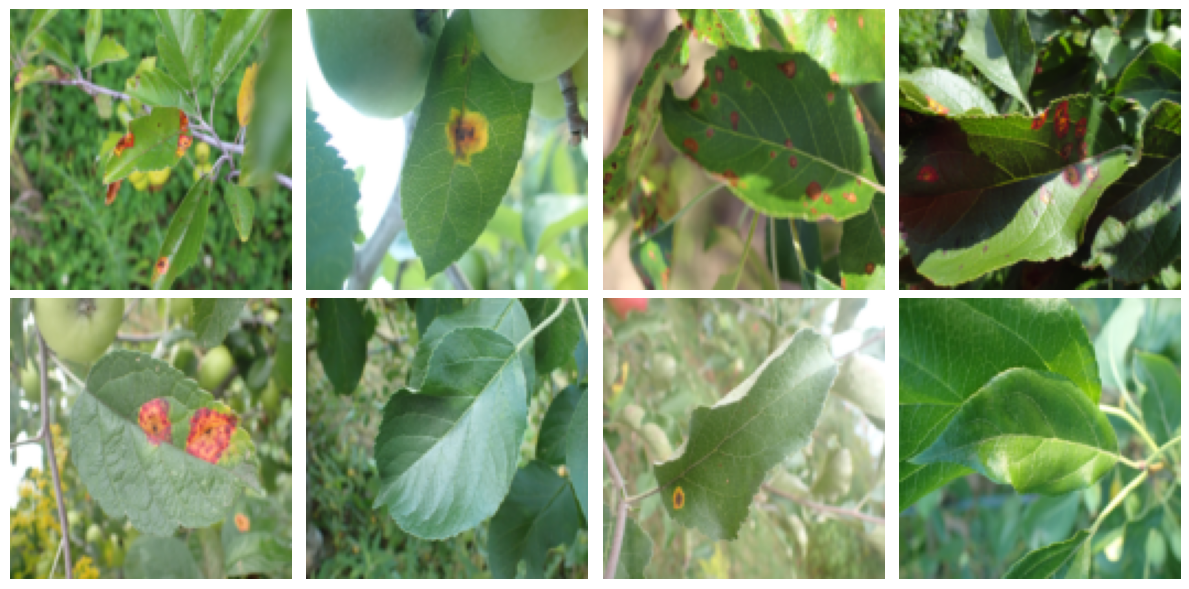

In [ ]:
""" 
View the images from the dataset. 
"""


def view_images(data_loader, num_images=8):
    # Extracting images from the data loader
    images, _ = next(iter(data_loader))

    # Defining the count
    images = images[:num_images]

    # Visualize images
    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        plt.subplot(2, num_images // 2, i + 1)
        image = images[i].permute(1, 2, 0)
        plt.imshow(image)
        plt.axis('off')
    plt.tight_layout()
    plt.show()


# Visualize images from the training dataset
view_images(training_loader)

In [8]:
""" 
Defining the basic CNN model to find how well it can predict plant disease. 
"""


class Base_CNN(nn.Module):
    def __init__(self):
        super(Base_CNN, self).__init__()
        # Definig 1 covolutional layer
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)  # Increased filters
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pooling = nn.MaxPool2d(2, 2)

        # Two fully connected layers
        self.fully_connected_1 = nn.Linear(64 * 32 * 32, 128)
        self.fully_connected_2 = nn.Linear(128, 3)  # 3 classes

    def forward(self, x):
        x = self.pooling(torch.relu(self.conv1(x)))
        x = self.pooling(torch.relu(self.conv2(x)))  # Second conv + pooling
        x = x.view(-1, 64 * 32 * 32)
        x = torch.relu(self.fully_connected_1(x))
        x = self.fully_connected_2(x)
        return x

In [9]:
""" 
Initializing the Basic CNN model with, 
    - Loss : CrossEntropyLoss
    - Optimizer : SGD
    - Learning Rate : 0.01
"""
base_model = Base_CNN()
criterion_base_CNN = nn.CrossEntropyLoss()
optimizer_base_CNN = torch.optim.SGD(base_model.parameters(), lr=0.01)

In [10]:
"""
Training the Base CNN model.
"""
# Flags to store values for visualization
training_losses = []
training_accuracies = []
validation_accuracies = []

print("Starting training...")
epochs_count = 10

for epoch in range(epochs_count):
    base_model.train()
    epoch_loss = 0.0
    training_correct = 0
    training_total = 0

    for inputs, labels in training_loader:
        optimizer_base_CNN.zero_grad()
        batch_outputs = base_model(inputs)
        batch_loss = criterion_base_CNN(batch_outputs, labels)
        batch_loss.backward()
        optimizer_base_CNN.step()

        epoch_loss += batch_loss.item()
        _, predicted = batch_outputs.max(1)
        training_total += labels.size(0)
        training_correct += predicted.eq(labels).sum().item()

    training_accuracy = 100. * training_correct / training_total
    training_losses.append(epoch_loss/len(training_loader))
    training_accuracies.append(training_accuracy)

    """ 
    Validation 
    """
    base_model.eval()
    validation_correct = 0
    validation_total = 0
    with torch.no_grad():
        for inputs, labels in validation_loader:
            outputs = base_model(inputs)
            _, predicted = outputs.max(1)
            validation_total += labels.size(0)
            validation_correct += predicted.eq(labels).sum().item()

    validation_accuray = 100. * validation_correct / validation_total
    validation_accuracies.append(validation_accuray)

    print(f'Completed Base_CNN Epoch : {epoch+1}/{epochs_count} :')
    print(f'Training Loss: {epoch_loss/len(training_loader):.3f}')
    print(f'Training Accuracy: {training_accuracy:.2f}%')
    print(f'Validation Accuracy: {validation_accuray:.2f}%\n')

Starting training...
Completed Base_CNN Epoch : 1/10 :
Training Loss: 1.090
Training Accuracy: 39.33%
Validation Accuracy: 33.33%

Completed Base_CNN Epoch : 2/10 :
Training Loss: 1.047
Training Accuracy: 47.73%
Validation Accuracy: 56.67%

Completed Base_CNN Epoch : 3/10 :
Training Loss: 0.961
Training Accuracy: 57.79%
Validation Accuracy: 35.00%

Completed Base_CNN Epoch : 4/10 :
Training Loss: 0.906
Training Accuracy: 57.19%
Validation Accuracy: 56.67%

Completed Base_CNN Epoch : 5/10 :
Training Loss: 0.807
Training Accuracy: 62.03%
Validation Accuracy: 36.67%

Completed Base_CNN Epoch : 6/10 :
Training Loss: 0.738
Training Accuracy: 68.31%
Validation Accuracy: 61.67%

Completed Base_CNN Epoch : 7/10 :
Training Loss: 0.727
Training Accuracy: 69.29%
Validation Accuracy: 53.33%

Completed Base_CNN Epoch : 8/10 :
Training Loss: 0.613
Training Accuracy: 74.81%
Validation Accuracy: 53.33%

Completed Base_CNN Epoch : 9/10 :
Training Loss: 0.590
Training Accuracy: 76.25%
Validation Accurac

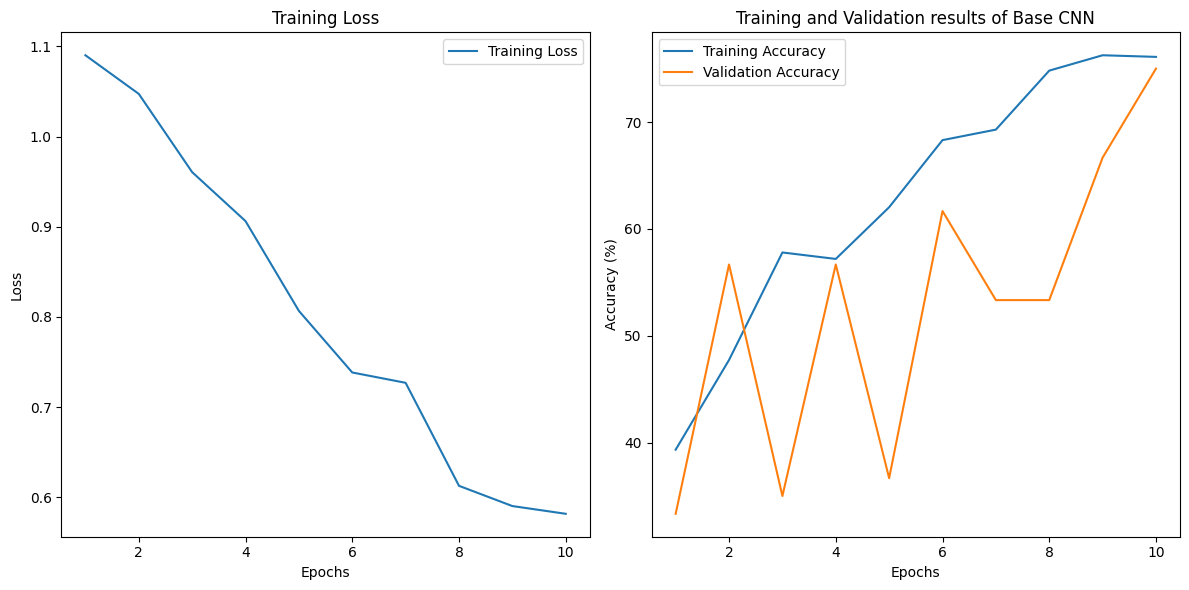

In [11]:
""" 
Visiualizing training and validation results of the Base model.
"""
plt.figure(figsize=(12, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs_count + 1), training_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs_count + 1),
         training_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs_count + 1), validation_accuracies,
         label='Validation Accuracy')
plt.title('Training and Validation results of Base CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.savefig('./plots/base_cnn_training_results.png')
plt.show()

In [12]:
""" 
Evaluating the base CNN model 
"""
base_model.eval()
testing_correct = 0
testing_total = 0
with torch.no_grad():
    for inputs, labels in testing_loader:
        outputs = base_model(inputs)
        _, predicted = outputs.max(1)
        testing_total += labels.size(0)
        testing_correct += predicted.eq(labels).sum().item()

test_accuracy = 100. * testing_correct / testing_total
print(f'Test Accuracy for Base CNN: {100.*testing_correct/testing_total:.2f}%')

Test Accuracy for Base CNN: 63.33%


## Implement Improvement 1

- Larger input size (224x224) for better feature detection
- Data augmentation with random flips for better generalization
- ImageNet normalization for training stability

In [13]:
image_transform_improved = transforms.Compose([
    transforms.Resize((224, 224)),          # Increased size from 32x32
    transforms.RandomHorizontalFlip(),      
    transforms.ToTensor(),      
    # using the mean and std of ImageNet images as they were calculated based on millions of images.            
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                       std=[0.229, 0.224, 0.225]) 
])


In [14]:
# Updated datasets with new transform
training_dataset_improved = datasets.ImageFolder(
    training_image_path, transform=image_transform_improved)
validation_dataset_improved = datasets.ImageFolder(
    validation_image_path, transform=image_transform_improved)
testing_dataset_improved = datasets.ImageFolder(
    testing_image_path, transform=image_transform_improved)

In [15]:
training_loader_improved = DataLoader(
    training_dataset_improved, batch_size=32, shuffle=True)
validation_loader_improved = DataLoader(
    validation_dataset_improved, batch_size=32)
testing_loader_improved = DataLoader(testing_dataset_improved, batch_size=32)

## Implement Improvement 2

- Three convolutional layers instead of one
- Added padding to maintain spatial dimensions
- Increased number of filters (32, 64, 128)


In [16]:
class ImprovedCNN(nn.Module):
    def __init__(self, num_classes):
        super(ImprovedCNN, self).__init__()
        
        # convolution layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        # pooling and fully connected layers
        self.pooling = nn.MaxPool2d(2, 2)
        self.fully_connected_1 = nn.Linear(128 * 28 * 28, 512)
        self.fully_connected_2 = nn.Linear(512, num_classes)
        
        # dropout - overfitting fix
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        
        x = self.pooling(torch.relu(self.conv1(x)))
        x = self.pooling(torch.relu(self.conv2(x)))
        x = self.pooling(torch.relu(self.conv3(x)))
        
        
        x = x.view(-1, 128 * 28 * 28)
        
        
        x = torch.relu(self.fully_connected_1(x))
        x = self.dropout(x)
        x = self.fully_connected_2(x)
        
        return x


In [17]:
""" 
initializing the improved cnn modell 
"""
num_classes = len(training_dataset_improved.classes)
improved_model = ImprovedCNN(num_classes)

#### Implement Improvement 3

- Using Adam optimizer instead of SGD
- Added dropout for regularization
- More epochs 


In [18]:
# Training components
improved_criterion = nn.CrossEntropyLoss()
improved_optimizer = torch.optim.Adam(
    improved_model.parameters(), lr=0.01)  # Changed to Adam

In [19]:
# Flags to store values for visualization
training_losses = []
training_accuracies = []
validation_accuracies = []
epochs_count = 10
best_val_acc = 0

In [20]:
# Training loop
print("Starting training...")

for epoch in range(epochs_count):
    improved_model.train()
    training_loss = 0.0
    training_correct = 0
    training_total = 0

    for inputs, labels in training_loader_improved:
        improved_optimizer.zero_grad()
        outputs = improved_model(inputs)
        loss = improved_criterion(outputs, labels)
        loss.backward()
        improved_optimizer.step()
        
        training_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        training_correct += (predicted == labels).sum().item()
        training_total += labels.size(0)

    # Calculate metrics
    epoch_loss = training_loss / len(training_loader_improved)
    epoch_accuracy = training_correct / training_total

    training_losses.append(epoch_loss)
    training_accuracies.append(epoch_accuracy)

    # Validation phase
    improved_model.eval()
    validation_correct = 0
    validation_total = 0
    with torch.no_grad():
        for inputs, labels in validation_loader_improved:
            outputs = improved_model(inputs)
            _, predicted = torch.max(outputs, 1)
            validation_correct += (predicted == labels).sum().item()
            validation_total += labels.size(0)

    validation_accuracy = validation_correct / validation_total
    validation_accuracies.append(validation_accuracy)
    # Save best model
    if validation_accuracy > best_val_acc:
        best_val_acc = validation_accuracy
        torch.save(improved_model.state_dict(), 'best_plant_disease_model.pth')

    print(f'Completed Improved CNN Epoch : {epoch+1}/{epochs_count} :')
    print(f'Training Loss: {epoch_loss/len(training_loader_improved):.3f}')
    print(f'Training Accuracy: {training_accuracy:.2f}%')
    print(f'Validation Accuracy: {validation_accuray:.2f}%\n')

Starting training...
Completed Improved CNN Epoch : 1/10 :
Training Loss: 0.417
Training Accuracy: 76.10%
Validation Accuracy: 75.00%

Completed Improved CNN Epoch : 2/10 :
Training Loss: 0.026
Training Accuracy: 76.10%
Validation Accuracy: 75.00%

Completed Improved CNN Epoch : 3/10 :
Training Loss: 0.026
Training Accuracy: 76.10%
Validation Accuracy: 75.00%

Completed Improved CNN Epoch : 4/10 :
Training Loss: 0.026
Training Accuracy: 76.10%
Validation Accuracy: 75.00%

Completed Improved CNN Epoch : 5/10 :
Training Loss: 0.026
Training Accuracy: 76.10%
Validation Accuracy: 75.00%

Completed Improved CNN Epoch : 6/10 :
Training Loss: 0.026
Training Accuracy: 76.10%
Validation Accuracy: 75.00%

Completed Improved CNN Epoch : 7/10 :
Training Loss: 0.026
Training Accuracy: 76.10%
Validation Accuracy: 75.00%

Completed Improved CNN Epoch : 8/10 :
Training Loss: 0.026
Training Accuracy: 76.10%
Validation Accuracy: 75.00%

Completed Improved CNN Epoch : 9/10 :
Training Loss: 0.026
Training

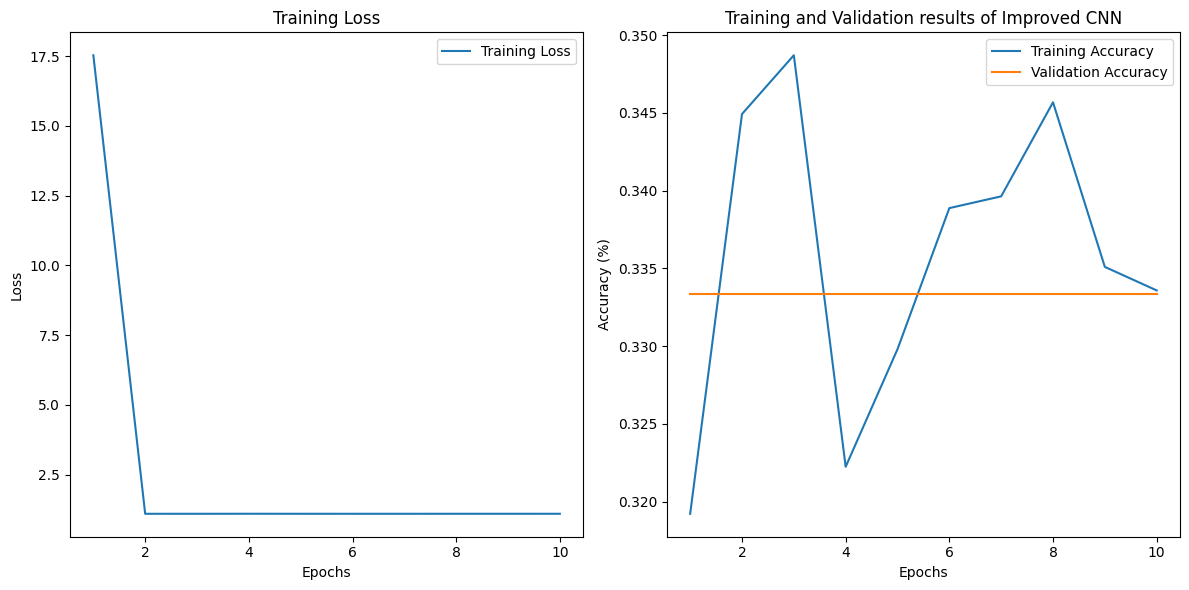

In [21]:
""" 
Visiualizing training and validation results of the Base model.
"""
plt.figure(figsize=(12, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs_count + 1), training_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs_count + 1),
         training_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs_count + 1), validation_accuracies,
         label='Validation Accuracy')
plt.title('Training and Validation results of Improved CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.savefig("./plots/Training and Validation results of Improved CNN.png")
plt.show()

#### Evaluating Improved Model. 

In [22]:
# Load the best model
improved_model.load_state_dict(torch.load('best_plant_disease_model.pth'))

/var/folders/qr/rqfn293x3zzgp2bfm_29pzk00000gn/T/ipykernel_33348/1298930184.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  improved_model.load_state_dict(torch.load('be

<All keys matched successfully>

In [23]:
# Evaluation function
def evaluate_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    improved_model.to(device)
    
    improved_model.eval()  # Set model to evaluation mode
    testing_correct = 0
    testing_total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            testing_correct += (predicted == labels).sum().item()
            testing_total += labels.size(0)
    
    testing_accuracy = testing_correct / testing_total
    print(f"Test Accuracy: {testing_accuracy*100:.2f}%")

In [24]:
evaluate_model(improved_model, testing_loader_improved)

Test Accuracy: 33.33%


## Hyper Parameter Optimization

Here we are planning to use GridSearch for the hyper parameter optimization.
For this we are planning to take Learning Rate, Batch Size and Number of Layers, Number of filters and Droupout rate hyper parameters for optimization.

In [25]:
"""
Defining the hyperparameters values. 
"""
learning_rates = [0.001, 0.0001]
batch_sizes = [16, 32]
optimizers = ['SGD', 'Adam']

In [26]:
"""  
Flags to store results
"""
results = []
best_hyperparams = None
best_validation_accuracy = 0

In [27]:
"""
Training model with different combination of parameters.
"""
for learning_rate, batch_size, optimizer_name in itertools.product(learning_rates, batch_sizes, optimizers):
    print(
        f"Testing hyperparameters: LR={learning_rate}, Batch Size={batch_size}, Optimizer={optimizer_name}")

    # Updating the dataloader based on current batch size
    training_loader = DataLoader(
        training_dataset_improved, batch_size=batch_size, shuffle=True)
    validation_loader = DataLoader(
        validation_dataset_improved, batch_size=batch_size)

    # Defining model and criterion
    model = ImprovedCNN(num_classes)
    criterion = nn.CrossEntropyLoss()

    # Updatng optimizer based on current optimizer
    if optimizer_name == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Training using current hyperparameters
    for epoch in range(5):
        model.train()
        for inputs, labels in training_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Validating the model using current hyperparameters
    model.eval()
    validation_correct = 0
    validation_total = 0
    with torch.no_grad():
        for inputs, labels in validation_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            validation_correct += (predicted == labels).sum().item()
            validation_total += labels.size(0)

    validation_accuracy = validation_correct / validation_total
    results.append((learning_rate, batch_size,
                   optimizer_name, validation_accuracy))
    print(f"Validation Accuracy: {validation_accuracy:.4f}")

    # Save the best hyperparameter model
    if validation_accuracy > best_validation_accuracy:
        best_validation_accuracy = validation_accuracy
        best_hyperparams = {'learning_rate': learning_rate,
                            'batch_size': batch_size, 'optimizer': optimizer_name}

Testing hyperparameters: LR=0.001, Batch Size=16, Optimizer=SGD
Validation Accuracy: 0.5000
Testing hyperparameters: LR=0.001, Batch Size=16, Optimizer=Adam
Validation Accuracy: 0.9000
Testing hyperparameters: LR=0.001, Batch Size=32, Optimizer=SGD
Validation Accuracy: 0.6000
Testing hyperparameters: LR=0.001, Batch Size=32, Optimizer=Adam
Validation Accuracy: 0.9333
Testing hyperparameters: LR=0.0001, Batch Size=16, Optimizer=SGD
Validation Accuracy: 0.3667
Testing hyperparameters: LR=0.0001, Batch Size=16, Optimizer=Adam
Validation Accuracy: 0.9000
Testing hyperparameters: LR=0.0001, Batch Size=32, Optimizer=SGD
Validation Accuracy: 0.5333
Testing hyperparameters: LR=0.0001, Batch Size=32, Optimizer=Adam
Validation Accuracy: 0.8833


Best Hyperparameters:
{'learning_rate': 0.001, 'batch_size': 32, 'optimizer': 'Adam'}
Best Validation Accuracy: 0.9333


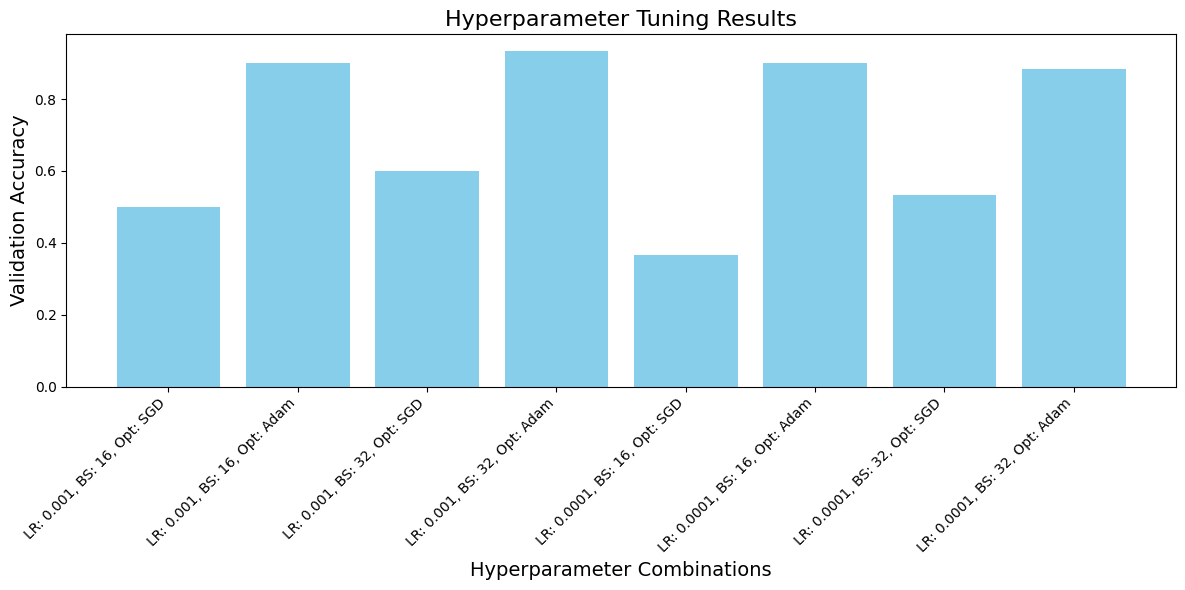

In [28]:
""" 
Visualizing the hyparparameter tunning results.
"""
print("Best Hyperparameters:")
print(best_hyperparams)
print(f"Best Validation Accuracy: {best_validation_accuracy:.4f}")

# Plotting results
hyperparameter_labels = [
    f"LR: {r[0]}, BS: {r[1]}, Opt: {r[2]}" for r in results]
validation_accuracies = [r[3] for r in results]

plt.figure(figsize=(12, 6))
plt.bar(hyperparameter_labels, validation_accuracies, color='skyblue')
plt.xlabel('Hyperparameter Combinations', fontsize=14)
plt.ylabel('Validation Accuracy', fontsize=14)
plt.title('Hyperparameter Tuning Results', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('./plots/hyperparameter_tuning_results.png')
plt.show()

Aftert the hyperparameter tunning we cann conclude that the best hyperparameters are :
- Learning Rate = 0.001
- Batch Size = 32
- Optimizer = Adam


Which gives the best accuracy of 93%